In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# from scipy.stats import norm
%matplotlib inline

# Data generators

In [2]:
class DataDistribution(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def sample(self, N):
        return np.random.normal(self.mu, self.sigma, N)

In [3]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + np.random.random(N) * 0.01

# Model

In [4]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, [None, real_dim], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    
    return inputs_real, inputs_z

In [5]:
# pre_D(x)
def pre_trainer(x, n_hidden=32, reuse=False, alpha=0.01):
    with tf.variable_scope('pre', reuse=reuse):
        h1 = tf.layers.dense(x, n_hidden, activation=None)
        h1 = tf.maximum(alpha * h1, h1) # leacky ReLU
        
        h2 = tf.layers.dense(h1, n_hidden, activation=None)
        h2 = tf.maximum(alpha * h2, h2) # leacky ReLU
        
        # logits and sigmoid output
        logits = tf.layers.dense(h2, 1, activation=None)
        out = tf.sigmoid(logits)
        return out

In [6]:
# G(z)
def generator(z, out_dim=1, n_hidden=32, reuse=False, alpha=0.01):
    with tf.variable_scope('generator', reuse=reuse):
        h1 = tf.layers.dense(z, n_hidden, activation=None)
        h1 = tf.maximum(alpha * h1, h1) # leacky ReLU
        
        h2 = tf.layers.dense(h1, n_hidden, activation=None)
        h2 = tf.maximum(alpha * h2, h2) # leacky ReLU
        
        # logits and tanh output
        logits = tf.layers.dense(h2, out_dim, activation=None)
#         out = tf.tanh(logits)
        return logits

In [7]:
# D(x)
def discriminator(x, n_hidden=32, reuse=False, alpha=0.01):
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.dense(x, n_hidden, activation=None)
        h1 = tf.maximum(alpha * h1, h1) # leacky ReLU
        
        h2 = tf.layers.dense(h1, n_hidden, activation=None)
        h2 = tf.maximum(alpha * h2, h2) # leacky ReLU
        
        # logits and sigmoid output
        logits = tf.layers.dense(h2, 1, activation=None)
        out = tf.sigmoid(logits)
        return out, logits

# Plotting functions

In [8]:
def test_samples(D, G, inputs_real, inputs_z, session, data, gen, sample_range, batch_size, num_points=10000, num_bins=100):
    # 1. decision boundary
    xs = np.linspace(-sample_range, sample_range, num_points)
    db = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        x_ = xs[batch_size * i:batch_size * (i + 1)]
        x_ = np.reshape(x_, [batch_size, 1])
        db[batch_size * i:batch_size * (i + 1)] = session.run(D, {inputs_real: x_})
    
    # bins for computing histogram
    bins = np.linspace(-sample_range, sample_range, num_bins)
    
    # 2. real data distribution
    d = data.sample(num_points)
    pd, _ = np.histogram(d, bins=bins, density=True)
    
    if G is not None:        
        # 3. generated samples
        zs = gen.sample(num_points)
        g = np.zeros((num_points, 1))
        for i in range(num_points // batch_size):
            z_ = zs[batch_size * i:batch_size * (i + 1)]
            z_ = np.reshape(z_, [batch_size, 1])
            g[batch_size * i:batch_size * (i + 1)] = session.run(G, {inputs_z: z_})
        pg, _ = np.histogram(g, bins=bins, density=True)
    else:
        pg = None
    return db, pd, pg

In [9]:
def plot_distributions(samps, sample_range):
    db, pd, pg = samps
    db_x = np.linspace(-sample_range, sample_range, len(db))
    p_x = np.linspace(-sample_range, sample_range, len(pd))
    f, ax = plt.subplots(1)
    ax.plot(db_x, db, label='decision boundary')
    ax.set_ylim(0, 1)
    ax.set_xlim(-sample_range, sample_range)
    plt.plot(p_x, pd, label='real data')
    if pg is not None:
        plt.plot(p_x, pg, label='generated data')
    plt.title('1D Generative Adversarial Network')
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

# Parameters

In [10]:
# parameters
mu, sigma = -1., 1.5
data_range = 5

input_size = 1 # Size of input
z_size = 1     # Size of latent vector to generator
n_hidden = 32  # Sizes of hidden layers
alpha = 0.01   # Leak factor for leaky ReLU
smooth = 0.1   # Smoothing 

d_learning_rate = 0.03
g_learning_rate = 0.03
n_initial_trainig_epochs = 1000
n_epochs = 3000
M = 150 # batch size

# Pre-training session

In [11]:
tf.reset_default_graph()

# Create our input placeholders
inputs_pre = tf.placeholder(tf.float32, [None, input_size], name='inputs_pre')
labels_pre = tf.placeholder(tf.float32, [None, input_size], name='labels_pre')

# Build the model
d_model_pre = pre_trainer(x=inputs_pre, n_hidden=n_hidden, reuse=False, alpha=alpha)

# Calculate losses
d_loss_pre = tf.reduce_mean(tf.square(d_model_pre - labels_pre))

# optimization
t_vars = tf.trainable_variables()
pre_vars = [var for var in t_vars if var.name.startswith('pre')]

learning_rate = 0.01
pre_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss_pre, var_list=pre_vars)

In [12]:
data = DataDistribution(mu, sigma)
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(n_initial_trainig_epochs):
        N = 1000
        d = data.sample(N)
        n_bins = 100
        histc, edges = np.histogram(d, bins=n_bins, density=True)
        
        # Estimated pdf is used as labels after normalization
        max_histc = np.max(histc)
        min_histc = np.min(histc)
        y_ = (histc - min_histc) / (max_histc - min_histc)
        x_ = edges[1:]
        
        x_ = np.reshape(x_, [n_bins, input_size])
        y_ = np.reshape(y_, [n_bins, input_size])
        
        # Run optimizers
        _, train_loss_pre = sess.run([pre_train_opt, d_loss_pre], feed_dict={inputs_pre: x_, labels_pre: y_})
        
        # Save losses to view after training
        losses.append(train_loss_pre)
        
        if (e+1) % 100 == 0:
            print("Pre-training Epoch {}/{}...".format(e+1, n_initial_trainig_epochs), "Loss: {:.4f}...".format(train_loss_pre))
        
        # at last step
        if e == n_initial_trainig_epochs-1:
            samps = test_samples(d_model_pre, None, inputs_pre, None, sess, data, None, data_range, M)
            
            # copy the learned weights over into a tmp array
            weights_P = sess.run(pre_vars)

Pre-training Epoch 100/1000... Loss: 0.0106...
Pre-training Epoch 200/1000... Loss: 0.0152...
Pre-training Epoch 300/1000... Loss: 0.0084...
Pre-training Epoch 400/1000... Loss: 0.0111...
Pre-training Epoch 500/1000... Loss: 0.0111...
Pre-training Epoch 600/1000... Loss: 0.0081...
Pre-training Epoch 700/1000... Loss: 0.0102...
Pre-training Epoch 800/1000... Loss: 0.0120...
Pre-training Epoch 900/1000... Loss: 0.0096...
Pre-training Epoch 1000/1000... Loss: 0.0111...


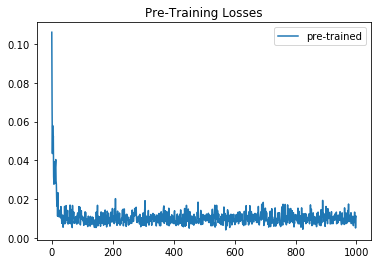

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses, label='pre-trained')
plt.title("Pre-Training Losses")
plt.legend()

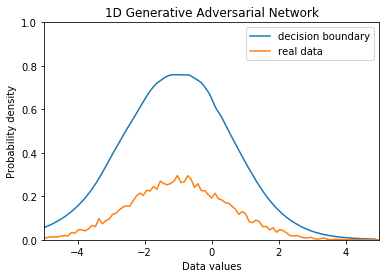

In [14]:
plot_distributions(samps, data_range)

# Build Net

In [15]:
tf.reset_default_graph()

# Create our input placeholders
inputs_real, inputs_z = model_inputs(real_dim=input_size, z_dim=z_size)

# Build the model
g_model = generator(z=inputs_z, out_dim=input_size, n_hidden=n_hidden, reuse=False, alpha=alpha)
d_model_real, d_logits_real = discriminator(x=inputs_real, n_hidden=n_hidden, reuse=False, alpha=alpha)
d_model_fake, d_logits_fake = discriminator(x=g_model, n_hidden=n_hidden, reuse=True, alpha=alpha)

In [16]:
# Calculate losses
# discriminator
real_labels = tf.ones_like(d_logits_real) * (1 - smooth)
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=real_labels))

fake_labels = tf.zeros_like(d_logits_real)
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=fake_labels))

# discriminator's loss is sum of real and fake
d_loss = d_loss_real + d_loss_fake

# generator
g_labels = tf.ones_like(d_logits_fake)
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_labels))

In [17]:
# optimization
# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)

In [18]:
data = DataDistribution(mu, sigma)
gen = GeneratorDistribution(data_range)

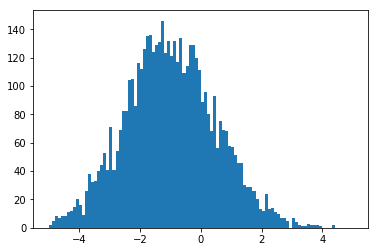

In [19]:
# show input real data distribution
temp_input = data.sample(5000)
plt.hist(temp_input, bins=100, range=[-data_range, data_range], align='mid')
plt.show()

# Training

In [20]:
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # copy weights from pre-training over to new D network
    for i, v in enumerate(d_vars):
        sess.run(v.assign(weights_P[i]))
    
    for e in range(n_epochs):
        x_ = data.sample(M * input_size) # sampled m-batch from p_data
        x_ = np.reshape(x_, [M, input_size])
        z_ = gen.sample(M * z_size)  # sample m-batch from noise prior
        z_ = np.reshape(z_, [M, z_size])
        
        # Run optimizers
        _ = sess.run(d_train_opt, feed_dict={inputs_real: x_, inputs_z: z_})
        _ = sess.run(g_train_opt, feed_dict={inputs_z: z_})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {inputs_real: x_, inputs_z: z_})
        train_loss_g = g_loss.eval({inputs_z: z_})
        
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        if (e+1) % 100 == 0:
            print("Epoch {}/{}...".format(e+1, n_epochs),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
        # save last training status for viewing
        if e == n_epochs-1:
            samps = test_samples(d_model_real, g_model, inputs_real, inputs_z, sess, data, gen, data_range, M)

Epoch 100/3000... Discriminator Loss: 1.8223... Generator Loss: 1.2294
Epoch 200/3000... Discriminator Loss: 1.5255... Generator Loss: 0.8858
Epoch 300/3000... Discriminator Loss: 1.4075... Generator Loss: 0.9994
Epoch 400/3000... Discriminator Loss: 1.3662... Generator Loss: 0.7886
Epoch 500/3000... Discriminator Loss: 1.2794... Generator Loss: 0.8742
Epoch 600/3000... Discriminator Loss: 1.1172... Generator Loss: 1.2298
Epoch 700/3000... Discriminator Loss: 1.4875... Generator Loss: 1.7769
Epoch 800/3000... Discriminator Loss: 1.3865... Generator Loss: 0.8245
Epoch 900/3000... Discriminator Loss: 1.3886... Generator Loss: 0.8066
Epoch 1000/3000... Discriminator Loss: 1.3761... Generator Loss: 0.8142
Epoch 1100/3000... Discriminator Loss: 1.4235... Generator Loss: 0.7804
Epoch 1200/3000... Discriminator Loss: 1.3042... Generator Loss: 0.9444
Epoch 1300/3000... Discriminator Loss: 1.3279... Generator Loss: 0.8343
Epoch 1400/3000... Discriminator Loss: 1.4293... Generator Loss: 0.7706
E

# Losses

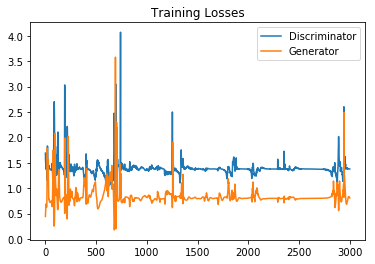

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Last generated results

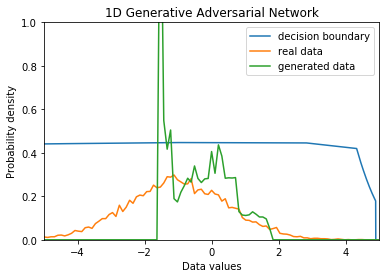

In [22]:
plot_distributions(samps, data_range)